In [1]:
using LazySets, Plots

In [2]:
using LazySets, Optim, Plots

┌ Info: Precompiling Optim [429524aa-4258-5aef-a3af-852621145aeb]
└ @ Base loading.jl:1278


In [3]:
H = rand(Hyperplane, dim=6);
Z = rand(Zonotope, dim=6);
X = Z ∩ H

Intersection{Float64,Zonotope{Float64,Array{Float64,1},Array{Float64,2}},Hyperplane{Float64,Array{Float64,1}}}(Zonotope{Float64,Array{Float64,1},Array{Float64,2}}([-0.5513605453005844, 0.13654033072179472, 0.6375880457011217, 3.473201203944964, -1.4675860999212202, 0.47991930579072595], [-0.6517835141603586 -1.2424518158202014 … 0.8269591340823754 -1.5705510425137341; -0.31707174350512596 1.5544185570100832 … -0.022871389797746545 0.6889074470381389; … ; 0.9264638620457589 -0.3129705077524748 … -0.3784257066683114 -1.6233126535963511; 0.6313300933841962 -0.5060858888894672 … 1.374614710194204 0.14840066700507545]), Hyperplane{Float64,Array{Float64,1}}([-0.6626612550495999, 0.7036896102639426, -0.15204574773242968, 0.4392818648141091, 0.5784039351090798, 0.20876468172957327], -1.2815742409445638), LazySets.IntersectionCache(-1))

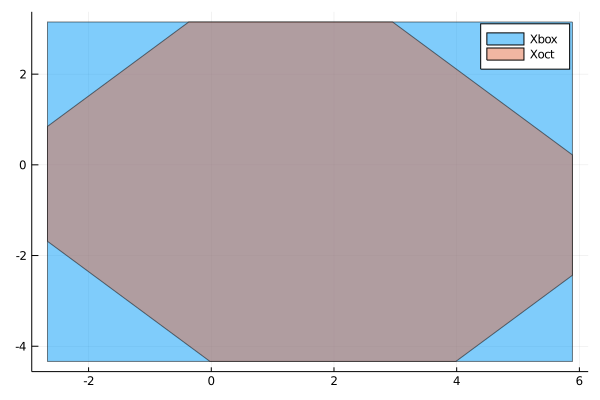

In [4]:
Xbox = overapproximate(X, BoxDirections)
Xoct = overapproximate(X, OctDirections);

plot(Projection(Xbox, [1,2]), lab="Xbox")
plot!(Projection(Xoct, [1,2]), lab="Xoct")

Aqui usamos que:

$$
\rho(d, X \cap Y) \leq \min\{ \rho(d, X), \rho(d, Y)\}
$$

La cota *no es tight* en general.

In [5]:
H = rand(Hyperplane, dim=2);
Z = rand(Zonotope, dim=2);
X = Z ∩ H

Xbox = overapproximate(X, BoxDirections)
Xoct = overapproximate(X, OctDirections);

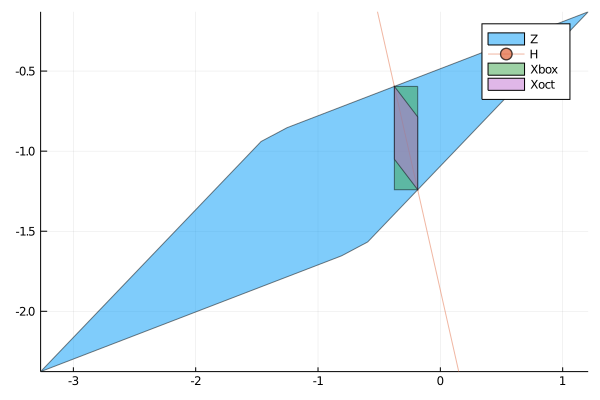

In [6]:
plot(Z, lab="Z")
plot!(H, lab="H")
plot!(Xbox, lab="Xbox")
plot!(Xoct, lab="Xoct")

## Reduccion a intersecciones en el plano

In [7]:
using LazySets: center

function _above(vec)
    return vec[2] > 0 || (vec[2] == 0 && vec[1] > 0)
end

# returns the support vector of Z ∩ L along direction (0, 1)
function bound_intersect_2D(Z::AbstractZonotope, L::Line2D)
    c = center(Z)
    P = copy(c)
    G = genmat(Z)
    r = ngens(Z)
    g(x) = view(G, :, x)
    for i = 1:r
        gi = g(i)
        if !_above(gi)
            gi .= -gi
        end
        P .= P - gi
    end
    G = sortslices(G, dims=2, by=x->atan(x[2], x[1])) # sort gens
    if P[1] < L.b
        G .= G[:,end:-1:1]
    end
    j = 1
    while isempty(intersection(LineSegment(P, P+2g(j)), L)) # TODO use `isdisjoint`
        P .= P + 2g(j)
        j += 1
        if j > size(G, 2)
            error("xxxxx")
        end
    end
    vec = intersection(LineSegment(P, P+2g(j)), L)
    return element(vec)[2]
end

# slower using hrep
function bound_intersect_2D_slow(Z::AbstractZonotope, L::Line2D)
    X = intersection(Z, L)
    return ρ([0.0, 1.0], X)
end

bound_intersect_2D_slow (generic function with 1 method)

In [8]:
G = rand(2, 6)
view(G, :, 4)

2-element view(::Array{Float64,2}, :, 4) with eltype Float64:
 0.4274597403486413
 0.2465568598298853

In [9]:
using LazySets.Approximations: AbstractDirections

function _overapproximate_projection_method(X::Intersection{N, <:AbstractZonotope{N}, <:Hyperplane{N}},
                                            dirs::AbstractDirections{N}) where {N}
    dim(X) == dim(dirs) || throw(ArgumentError("the dimension of the set, $(dim(X)) doesn't match the dimension " *
                                               "of the template, $(dim(dirs))"))
    Z, G = X.X, X.Y
    
    if isdisjoint(Z, G)
        return EmptySet{N}(dim(Z))
    end

    n = G.a                    # normal vector to the hyperplane
    γ = G.b                    # displacement of the hyperplane
    Lᵧ = Line2D([one(N), zero(N)], γ)  # line (x, y) : x = γ

    constraints = Vector{HalfSpace{N, eltype(dirs)}}()
    for l in dirs
       Πₙₗ = vcat(n', l')         # projection map
       πZₙₗ = linear_map(Πₙₗ, Z)
       
       #ρₗ = bound_intersect_2D(πZₙₗ, Lᵧ)
       ρₗ = bound_intersect_2D_slow(πZₙₗ, Lᵧ)
       
       push!(constraints, HalfSpace(l, ρₗ))
    end
    T = isbounding(dirs) ? HPolytope : HPolyhedron
    return T(constraints)
end

function _overapproximate_projection_method(X::Intersection{N, <:AbstractZonotope{N}, <:Hyperplane{N}}, dirs::Type{<:AbstractDirections{N}}) where {N}
    _overapproximate_projection_method(X, dirs(dim(X)))
end

_overapproximate_projection_method (generic function with 2 methods)

is_intersection_empty(Z, G) = false


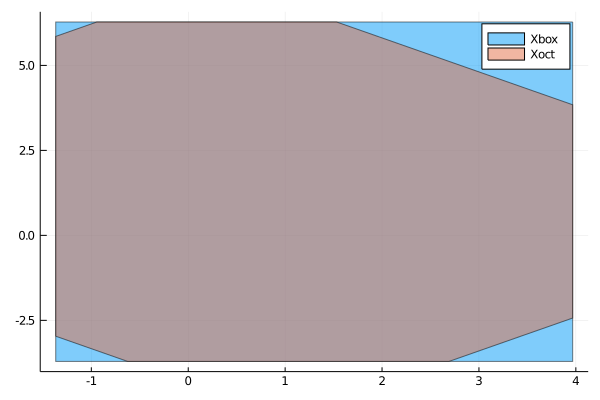

In [10]:
G = rand(Hyperplane, dim=6);
Z = rand(Zonotope, dim=6);
X = Z ∩ G

@show is_intersection_empty(Z, G)

Xbox = overapproximate(X, BoxDirections)
Xoct = overapproximate(X, OctDirections);

plot(Projection(Xbox, [1,2]), lab="Xbox")
plot!(Projection(Xoct, [1,2]), lab="Xoct")

In [11]:
Qbox = _overapproximate_projection_method(X, BoxDirections(dim(X)));
Qoct = _overapproximate_projection_method(X, OctDirections(dim(X)));

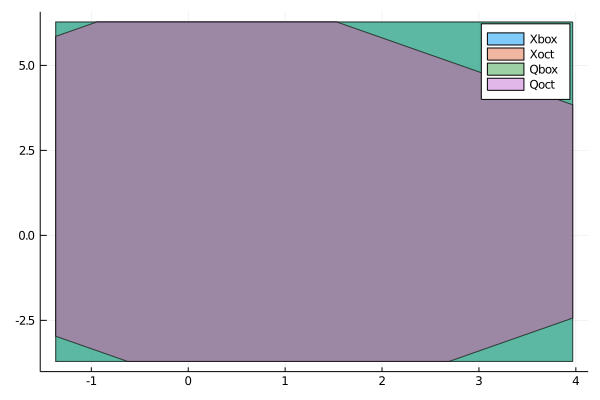

In [12]:
plot!(Projection(Qbox, [1, 2]), lab="Qbox")
plot!(Projection(Qoct, [1, 2]), lab="Qoct")

is_intersection_empty(Z, G) = false


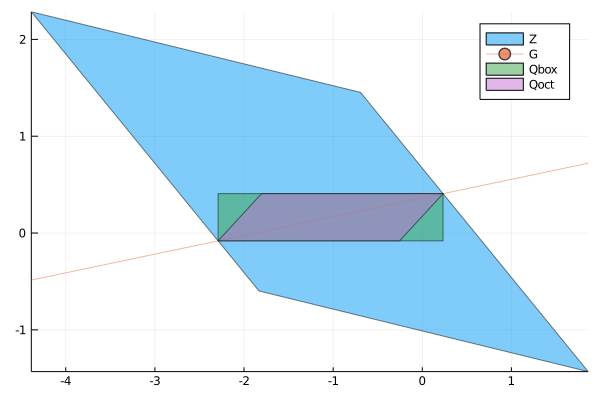

In [26]:
n = 2
G = rand(Hyperplane, dim=n);
Z = rand(Zonotope, dim=n);
X = Z ∩ G

@show is_intersection_empty(Z, G)

Xbox = overapproximate(X, BoxDirections)
Xoct = overapproximate(X, OctDirections);

plot(Z, lab="Z")
plot!(G, lab="G")

#plot(Projection(Xbox, [1,2]), lab="Xbox")
#plot!(Projection(Xoct, [1,2]), lab="Xoct")

Qbox = _overapproximate_projection_method(X, BoxDirections(dim(X)));
Qoct = _overapproximate_projection_method(X, OctDirections(dim(X)))
            
plot!(Projection(Qbox, [1, 2]), lab="Qbox")
plot!(Projection(Qoct, [1, 2]), lab="Qoct")

In [14]:
@time Xoct = overapproximate(X, OctDirections);
@time Qoct = _overapproximate_projection_method(X, OctDirections(dim(X)));

  0.000832 seconds (17.32 k allocations: 1.301 MiB)
  0.002455 seconds (5.99 k allocations: 528.078 KiB)


In [15]:
using LinearAlgebra

In [16]:
dot(nullspace(hcat(G.a)'), G.a)

1.3877787807814457e-17

  0.000287 seconds (7.10 k allocations: 712.188 KiB)
  0.003441 seconds (11.48 k allocations: 899.312 KiB)


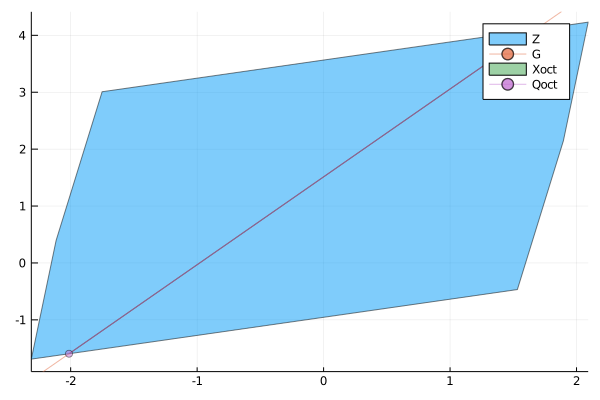

In [83]:
using Polyhedra, CDDLib
n = 2
G = rand(Hyperplane, dim=n);
Z = rand(Zonotope, dim=n);
X = Z ∩ G

# we add the normal direction to the hyperplane
#q = nullspace(hcat(G.a)')[:]
q = G.a
dirs = CustomDirections(vcat(collect(OctDirections{Float64, Vector{Float64}}(n)), [q, -q]));
#dirs = OctDirections{Float64, Vector{Float64}}(n)

@time Xoct = overapproximate(X, dirs);
@time Qoct = _overapproximate_projection_method(X, dirs)

plot(Z, lab="Z")
plot!(G, lab="G")
plot!(Projection(Xoct, [1, 2]), lab="Xoct")
plot!(Projection(Qoct, [1, 2]), lab="Qoct")

In [79]:
Qoct ⊆ Xoct

true

In [80]:
Xoct ⊆ Qoct

false